# 0. Importación de librerías

In [88]:
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.models import load_model
from tqdm.keras import TqdmCallback
import os
import keras
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tqdm.notebook import tqdm # Usar la versión específica para Notebooks
import torch
import lpips


# 1. Funcion para cálculo de métricas

In [94]:
device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_model = lpips.LPIPS(net='alex').to(device_torch)
lpips_model.eval()

def compute_lpips_torch(img1, img2):
    t1 = torch.tensor(img1).permute(2,0,1).unsqueeze(0).float()
    t2 = torch.tensor(img2).permute(2,0,1).unsqueeze(0).float()

    t1 = t1 * 2 - 1
    t2 = t2 * 2 - 1

    t1 = t1.to(device_torch)
    t2 = t2.to(device_torch)

    with torch.no_grad():
        dist = lpips_model(t1, t2)

    return dist.item()

def evaluate_model(model, dataset, num_samples=1000):
    ssim_scores = []
    psnr_scores = []
    lpips_scores = []

    count = 0
    
    pbar = tqdm(total=num_samples, desc="Procesando imágenes")
    for gray_batch, real_rgb_batch in dataset:
        if hasattr(model, 'encoder') and hasattr(model, 'decoder'):
            _, _, z = model.encoder(gray_batch)
            pred_rgb_batch = model.decoder(z)
        else:
            pred_rgb_batch = model(gray_batch, training=False)
        
        batch_size = gray_batch.shape[0]
        current_batch_count = min(batch_size, num_samples - count)
        
        for i in range(current_batch_count):
            real_img = real_rgb_batch[i]
            pred_img = pred_rgb_batch[i]

            real_tensor_4d = tf.expand_dims(real_img, 0)
            pred_tensor_4d = tf.expand_dims(pred_img, 0)

            ssim = tf.image.ssim(real_tensor_4d, pred_tensor_4d, max_val=1.0)
            psnr = tf.image.psnr(real_tensor_4d, pred_tensor_4d, max_val=1.0)

            ssim_scores.append(float(ssim.numpy()[0]))
            psnr_scores.append(float(psnr.numpy()[0]))

            lp = compute_lpips_torch(real_img.numpy(), pred_img.numpy())
            lpips_scores.append(lp)

            count += 1
        
        pbar.update(current_batch_count)

        if count >= num_samples:
            break
            
    pbar.close()

    mean_ssim = np.mean(ssim_scores)
    mean_psnr = np.mean(psnr_scores)
    mean_lpips = np.mean(lpips_scores)

    print("\nResultados Finales:")
    print("-" * 30)
    print(f"SSIM : {mean_ssim:.4f}")
    print(f"PSNR : {mean_psnr:.4f}")
    print(f"LPIPS: {mean_lpips:.4f}")
    print("-" * 30)

    return mean_ssim, mean_psnr, mean_lpips

LPIPS usando dispositivo: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


# 2. Preproceso del dataset

In [13]:
train_path = "/kaggle/input/stl10/unlabeled_images"
val_path = "/kaggle/input/stl10/train_images"
test_path = "/kaggle/input/stl10/test_images"

IMG_SIZE = (96, 96)
BATCH_SIZE = 32
SEED = 42

def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    gray = tf.image.rgb_to_grayscale(img)
    return gray, img  

train_files = tf.data.Dataset.list_files(os.path.join(train_path, "*.png"), seed=SEED)
val_files = tf.data.Dataset.list_files(os.path.join(val_path, "*.png"), seed=SEED)
test_files = tf.data.Dataset.list_files(os.path.join(test_path, "*.png"), seed=SEED)

train_dataset = train_files.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(2048, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = val_files.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = test_files.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Verificando dimensiones del primer batch:")
for gray, color in train_dataset.take(1):
    print("Input (B/N):", gray.shape)  # Debería ser (32, 96, 96, 1)
    print("Target (RGB):", color.shape) # Debería ser (32, 96, 96, 3)

Verificando dimensiones del primer batch:
Input (B/N): (32, 96, 96, 1)
Target (RGB): (32, 96, 96, 3)


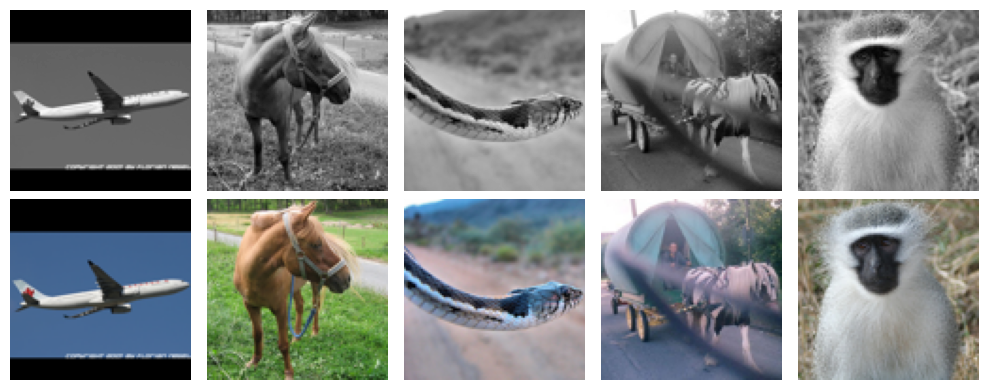

In [2]:
def mostrar_pares_grid(dataset, n=5):
    for gray_batch, color_batch in dataset.take(1):
        plt.figure(figsize=(n*2, 4))
        for i in range(n):
            gray = gray_batch[i].numpy().squeeze()
            color = color_batch[i].numpy()  

            plt.subplot(2, n, i+1)
            plt.imshow(gray, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.ylabel("Gris")

            plt.subplot(2, n, n+i+1)
            plt.imshow(color)
            plt.axis('off')
            if i == 0:
                plt.ylabel("Color")
        
        plt.tight_layout()
        plt.show()

mostrar_pares_grid(train_dataset, n=5)

In [53]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# 2. U-Net Autoencoder

In [24]:
def simple_autoencoder(input_shape=(96,96,1)):
    inputs = layers.Input(shape=input_shape)
    x1 = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    p1 = layers.MaxPooling2D(2)(x1)

    x2 = layers.Conv2D(64, 3, padding="same", activation="relu")(p1)
    p2 = layers.MaxPooling2D(2)(x2)

    x3 = layers.Conv2D(128, 3, padding="same", activation="relu")(p2)
    p3 = layers.MaxPooling2D(2)(x3)

    b = layers.Conv2D(256, 3, padding="same", activation="relu")(p3)

    u3 = layers.UpSampling2D(2)(b)
    u3 = layers.Concatenate()([u3, x3])
    d3 = layers.Conv2D(128, 3, padding="same", activation="relu")(u3)

    u2 = layers.UpSampling2D(2)(d3)
    u2 = layers.Concatenate()([u2, x2])
    d2 = layers.Conv2D(64, 3, padding="same", activation="relu")(u2)

    u1 = layers.UpSampling2D(2)(d2)
    u1 = layers.Concatenate()([u1, x1])
    d1 = layers.Conv2D(32, 3, padding="same", activation="relu")(u1)
    outputs = layers.Conv2D(3, 1, padding="same", activation="sigmoid")(d1)

    autoencoder = models.Model(inputs, outputs, name="simple_colorizer")
    return autoencoder

In [27]:
autoencoder_simple = simple_autoencoder()

autoencoder_simple.compile(
    optimizer="adam",
    loss="mse" 
)


autoencoder_simple.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [28]:
keras.saving.save_model(autoencoder_simple, 'autoencoder_simple.keras')

In [ ]:
def show_result(i):
    plt.figure(figsize=(10,3))

    # Imagen de entrada 
    plt.subplot(1,3,1)
    plt.imshow(gray_input[i].numpy().squeeze(), cmap="gray")
    plt.title("Input (Gray)")
    plt.axis("off")

    # Predicción del modelo
    plt.subplot(1,3,2)
    plt.imshow(predicted[i])
    plt.title("Predicted Color")
    plt.axis("off")

    # Imagen real
    plt.subplot(1,3,3)
    plt.imshow(true_color[i])
    plt.title("Real Color")
    plt.axis("off")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


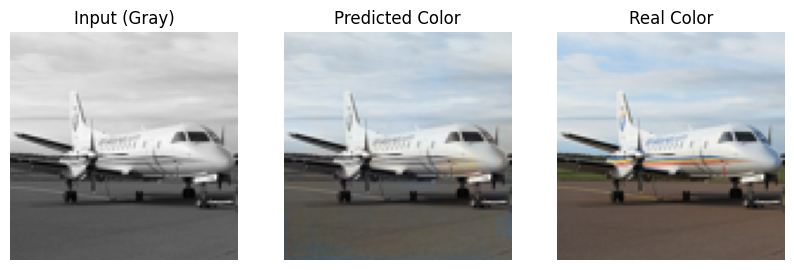

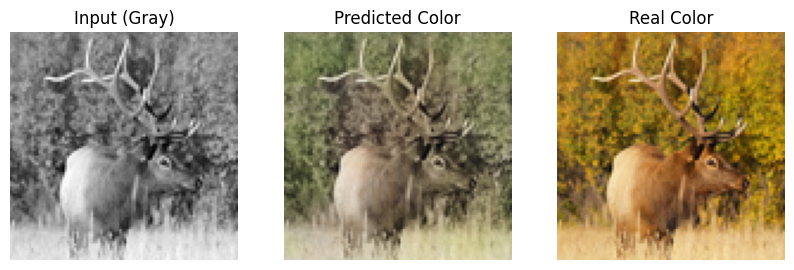

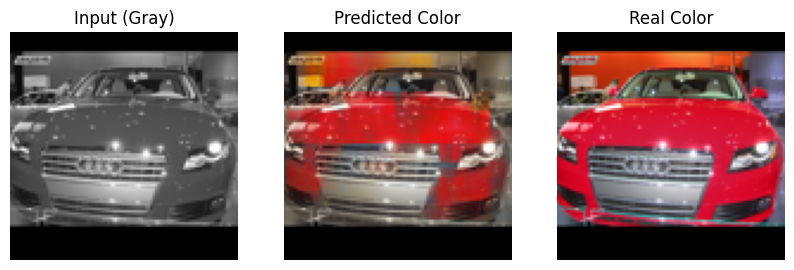

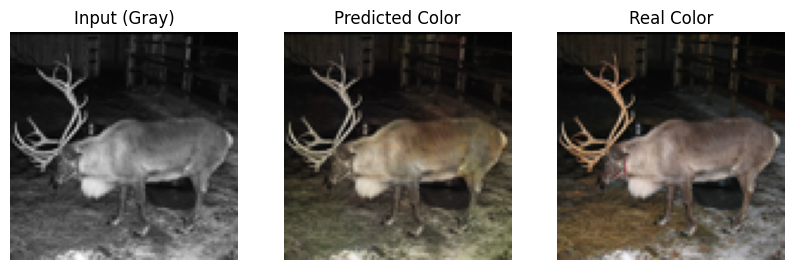

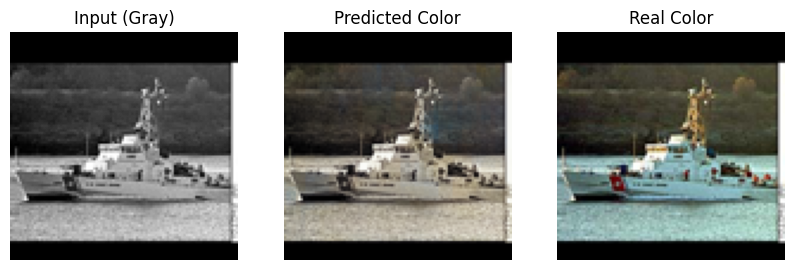

In [37]:
for gray_batch, color_batch in test_dataset.take(1):
    gray_input = gray_batch 
    true_color = color_batch 
    break

predicted = autoencoder_simple.predict(gray_input)

for i in range(5):
    show_result(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


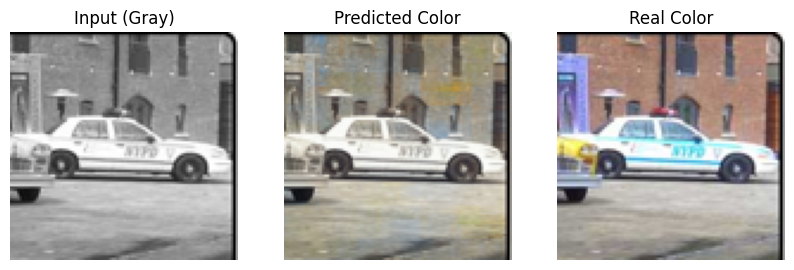

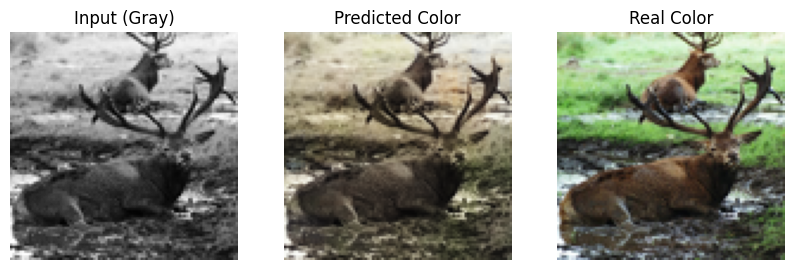

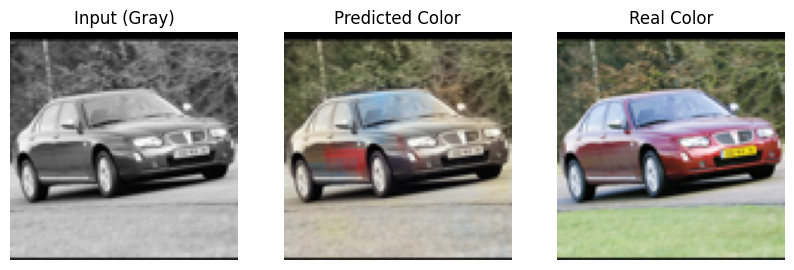

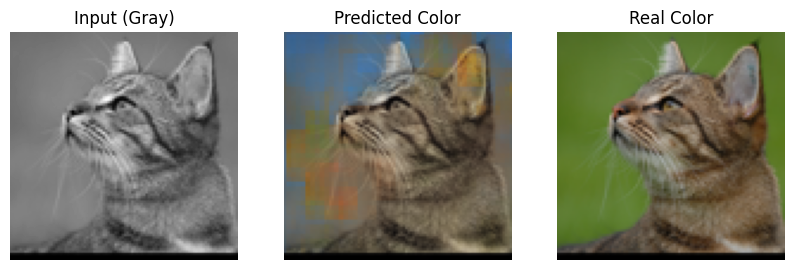

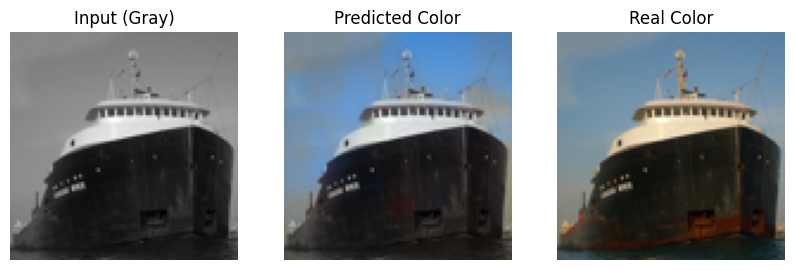

In [81]:
for gray_batch, color_batch in test_dataset.take(1):
    gray_input = gray_batch 
    true_color = color_batch 
    break

predicted = autoencoder_simple.predict(gray_input)

for i in range(5):
    show_result(i)

In [95]:
ssim, psnr,lpips = evaluate_model(autoencoder_simple,test_dataset)

Procesando imágenes:   0%|          | 0/1000 [00:00<?, ?it/s]


Resultados Finales:
------------------------------
SSIM : 0.9323
PSNR : 25.3312
LPIPS: 0.1345
------------------------------


# 3. ResU-Net

In [2]:
def residual_block(x, filters, kernel_size=3):
    res = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    if res.shape[-1] != filters:
        res = layers.Conv2D(filters, 1, padding='same')(res)

    x = layers.Add()([x, res])
    x = layers.Activation('relu')(x)
    return x

def autoencoder(input_shape=(96,96,1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x1 = residual_block(x, 64)
    p1 = layers.MaxPooling2D((2,2))(x1)

    x2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2,2))(x2)

    x3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D((2,2))(x3)

    b = residual_block(p3, 512)

    # Decoder
    u3 = layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu')(b)
    x = layers.Concatenate()([u3, x3])
    x = residual_block(x, 256)

    u2 = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.Concatenate()([u2, x2])
    x = residual_block(x, 128)

    u1 = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.Concatenate()([u1, x1])
    x = residual_block(x, 64)

    # Output: ¡IMPORTANTE! → force float32 para evitar problemas con sigmoid en float16
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    return model


autoencoder = autoencoder(input_shape=(96,96,1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
autoencoder.compile(optimizer=optimizer, loss='mse')

autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

Precision: <DTypePolicy "mixed_float16">


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1765192362.204821      88 service.cc:148] XLA service 0x784b8c00c330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765192362.205438      88 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765192364.188642      88 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765192389.051869      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [3]:
keras.saving.save_model(autoencoder, 'autoencoder.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


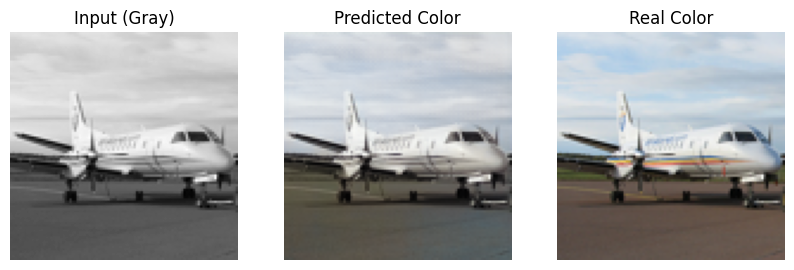

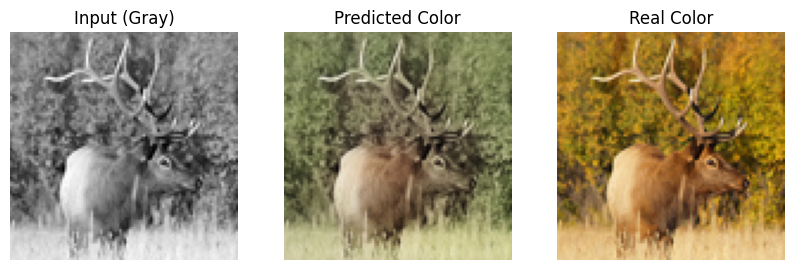

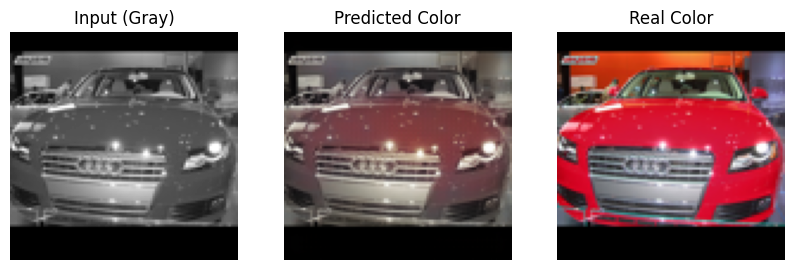

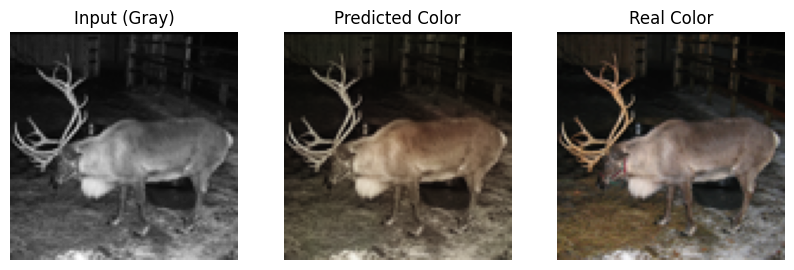

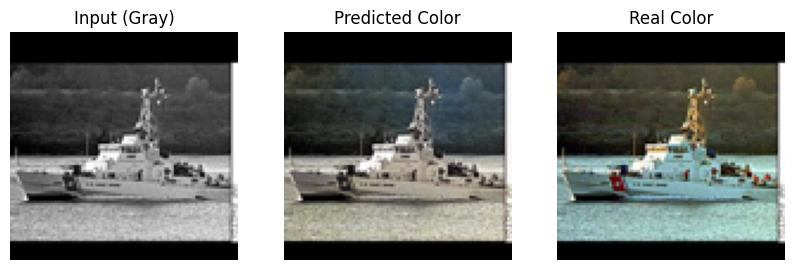

In [40]:
predicted = autoencoder.predict(gray_input)

for i in range(5):
    show_result(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


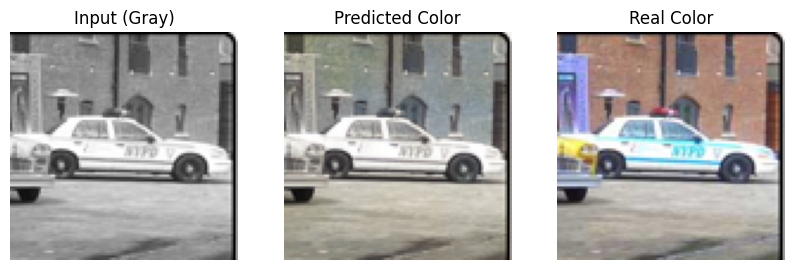

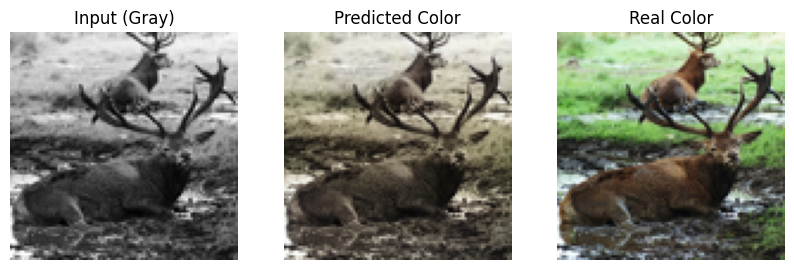

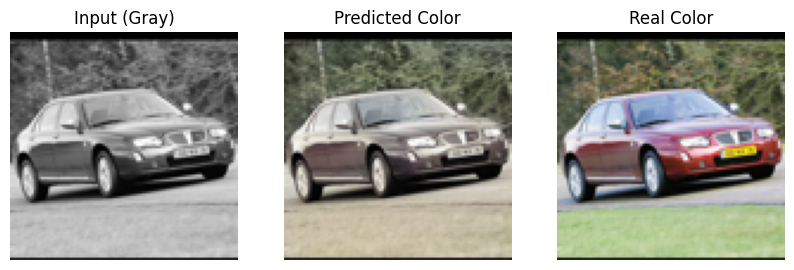

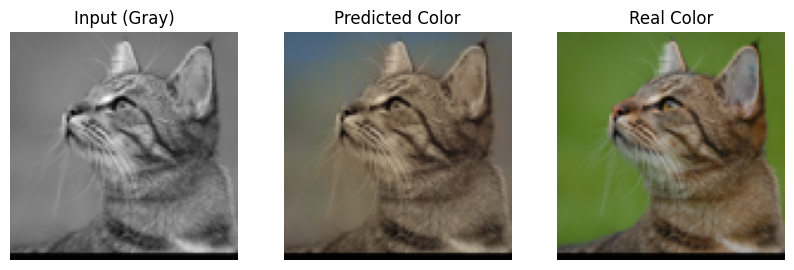

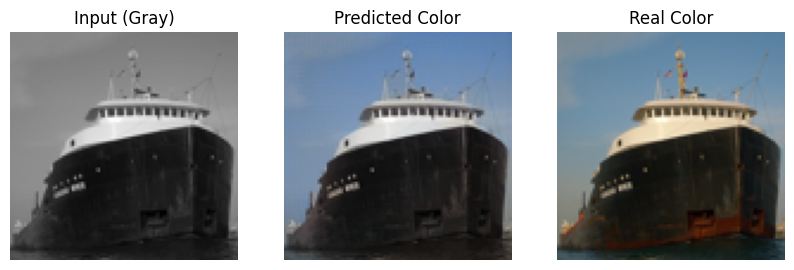

In [82]:
predicted = autoencoder.predict(gray_input)

for i in range(5):
    show_result(i)

In [96]:
ssim, psnr,lpips = evaluate_model(autoencoder,test_dataset)

Procesando imágenes:   0%|          | 0/1000 [00:00<?, ?it/s]


Resultados Finales:
------------------------------
SSIM : 0.9360
PSNR : 25.0441
LPIPS: 0.1466
------------------------------


# 4. VAE Denso

In [98]:
from tensorflow.keras import layers, models, backend as K

LATENT_DIM = 256

def build_encoder(input_shape=(96,96,1), latent_dim=LATENT_DIM):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean), dtype=z_mean.dtype)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = layers.Lambda(
        sampling,
        output_shape=(latent_dim,)
    )([z_mean, z_log_var])
    
    return models.Model(inputs, [z, z_mean, z_log_var], name="encoder")

def build_decoder(output_shape=(96,96,3), latent_dim=LATENT_DIM):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(12*12*256, activation='relu')(inputs)
    x = layers.Reshape((12,12,256))(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)
    return models.Model(inputs, outputs, name="decoder")

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
        
    def train_step(self, data):
            gray, color = data
            
            with tf.GradientTape() as tape:
                z, z_mean, z_log_var = self.encoder(gray)
                reconstruction = self.decoder(z)
       
                data_true = tf.cast(color, tf.float32)
                data_pred = tf.cast(reconstruction, tf.float32)
                
                z_mean = tf.cast(z_mean, tf.float32)
                z_log_var = tf.cast(z_log_var, tf.float32)
    
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(tf.square(data_true - data_pred), axis=[1, 2, 3])
                )
                
                kl_loss = -0.5 * tf.reduce_mean(
                    tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
                )
                
                total_loss = reconstruction_loss + kl_loss
            
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()
            }
    
    def call(self, inputs):
        z, _, _ = self.encoder(inputs)
        return self.decoder(z)


encoder = build_encoder()
decoder = build_decoder()
dvae = VAE(encoder, decoder)
dvae.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

dvae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
encoder.save('encoder_dense.keras')
decoder.save('decoder_dense.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


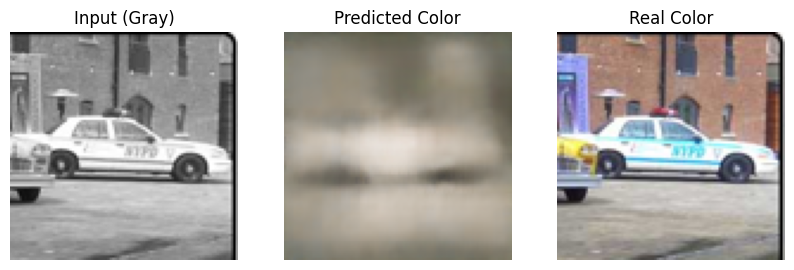

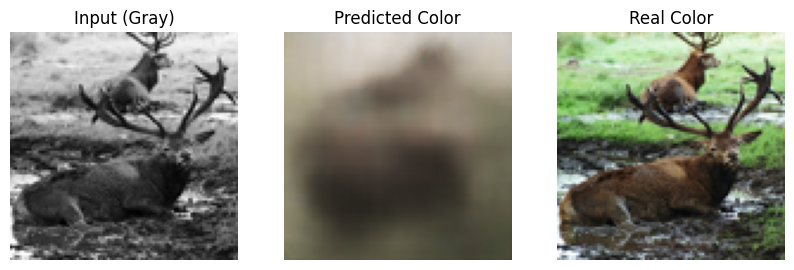

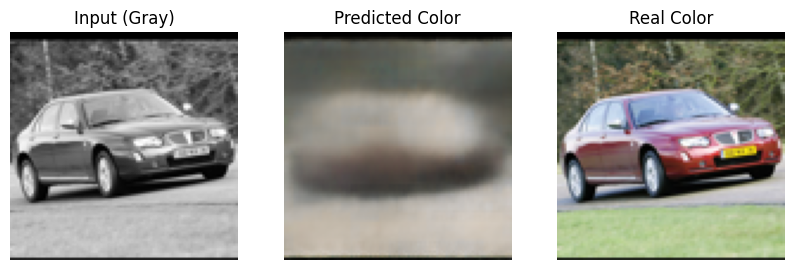

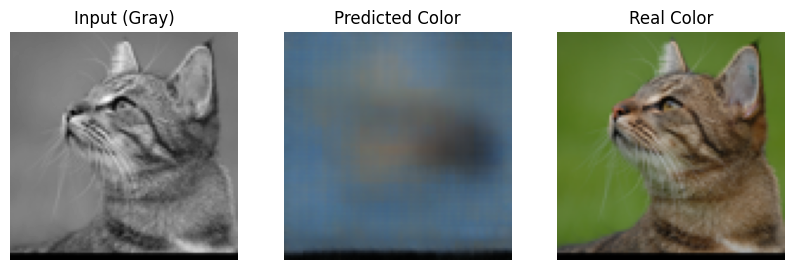

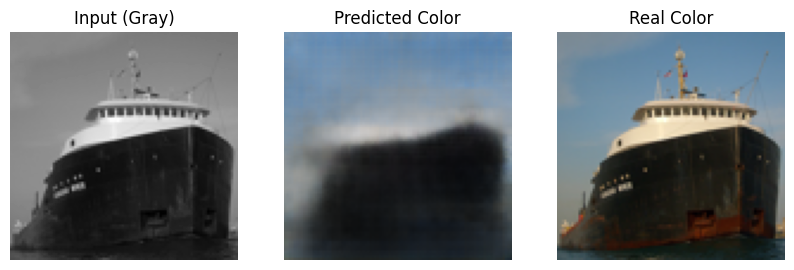

In [102]:
predicted = dvae.predict(gray_input)

for i in range(5):
    show_result(i)

In [101]:
ssim, psnr,lpips = evaluate_model(dvae,test_dataset)

Procesando imágenes:   0%|          | 0/1000 [00:00<?, ?it/s]


Resultados Finales:
------------------------------
SSIM : 0.0600
PSNR : 6.3406
LPIPS: 0.6884
------------------------------


# 5. VAE Convolucional

In [61]:
mixed_precision.set_global_policy('float32')

LATENT_DIM = 256
KL_WEIGHT = 0.0001
LEARNING_RATE = 1e-3

In [65]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim1 = tf.shape(z_mean)[1]
        dim2 = tf.shape(z_mean)[2]
        dim3 = tf.shape(z_mean)[3]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim1, dim2, dim3))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_cvae(input_shape=(96, 96, 1), latent_dim=256):
    encoder_inputs = keras.Input(shape=input_shape, name="encoder_input")
    
    x = layers.Conv2D(64, 3, strides=2, padding="same", use_bias=False)(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x) # 48x48
    
    x = layers.Conv2D(128, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x) # 24x24
    
    x = layers.Conv2D(256, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x) # 12x12
    
    # Espacio Latente
    z_mean = layers.Conv2D(latent_dim, 3, padding="same", name="z_mean")(x)
    z_log_var = layers.Conv2D(latent_dim, 3, padding="same", name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    latent_inputs = keras.Input(shape=(12, 12, latent_dim), name="z_sampling")
    
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", use_bias=False)(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same", name="rgb_output")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return encoder, decoder

class ColorizationVAE(keras.Model):
    def __init__(self, encoder, decoder, kl_weight=0.0001, **kwargs):
        super(ColorizationVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        gray_input = data[0]
        real_rgb = data[1]

        with tf.GradientTape() as tape:
            # Forward pass completo
            z_mean, z_log_var, z = self.encoder(gray_input)
            reconstruction = self.decoder(z)
            
            # Reconstrucción (MAE)
            recon_loss = tf.reduce_mean(tf.reduce_sum(
                tf.abs(real_rgb - reconstruction), axis=(1, 2, 3)
            ))
            
            # Divergencia KL
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1, 2, 3)))
            
            total_loss = recon_loss + (self.kl_weight * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        gray_input = data[0]
        real_rgb = data[1]

        z_mean, z_log_var, z = self.encoder(gray_input)
        reconstruction = self.decoder(z)

        recon_loss = tf.reduce_mean(tf.reduce_sum(
            tf.abs(real_rgb - reconstruction), axis=(1, 2, 3)
        ))
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1, 2, 3)))
        
        total_loss = recon_loss + (self.kl_weight * kl_loss)

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [66]:
encoder, decoder = build_cvae(latent_dim=LATENT_DIM)
vae = ColorizationVAE(encoder, decoder, kl_weight=KL_WEIGHT)

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

history = vae.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


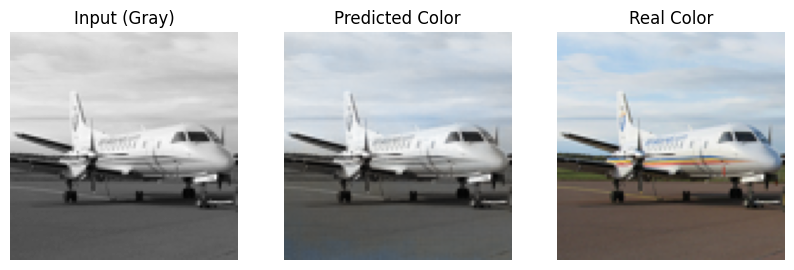

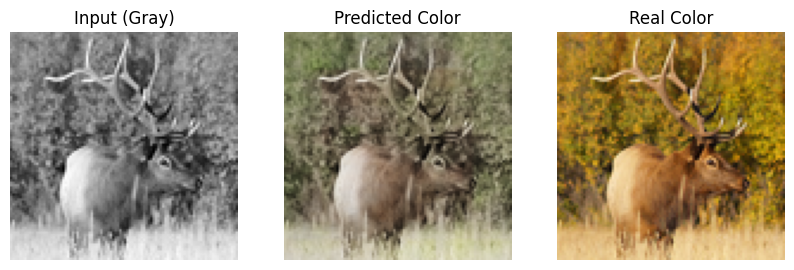

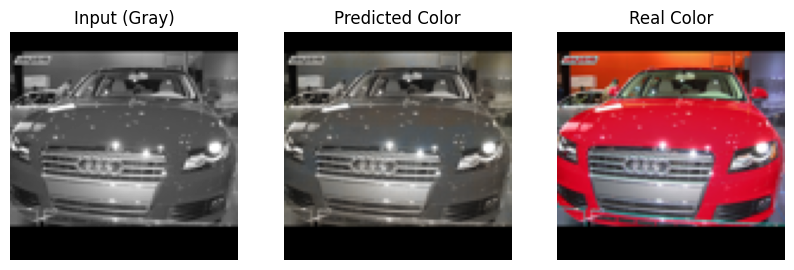

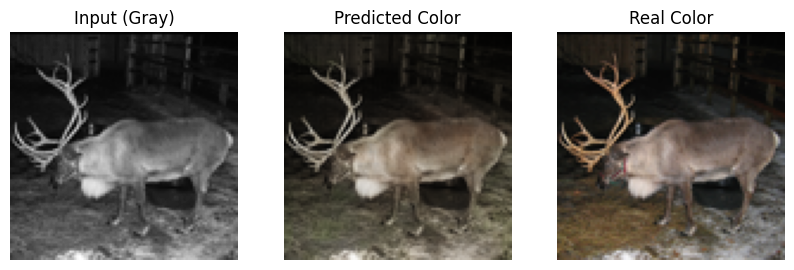

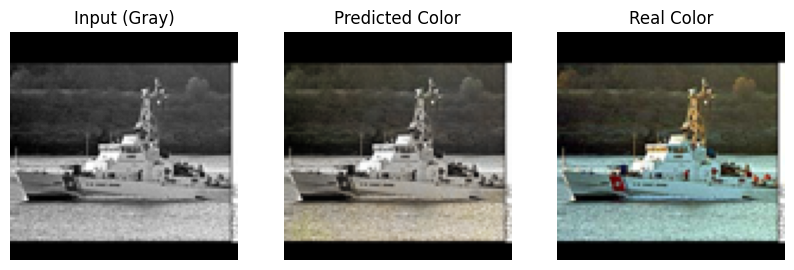

In [67]:
predicted = vae.predict(gray_input)

for i in range(5):
    show_result(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


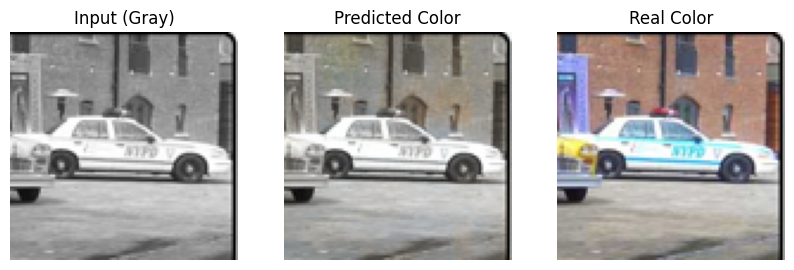

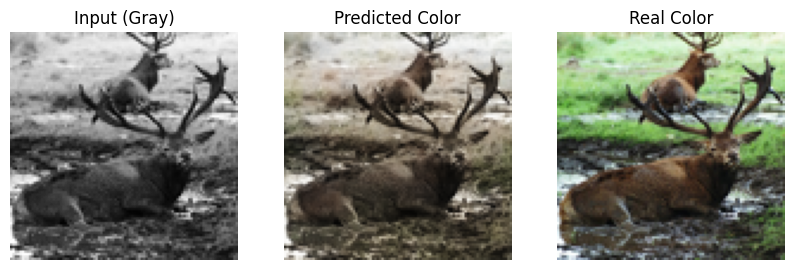

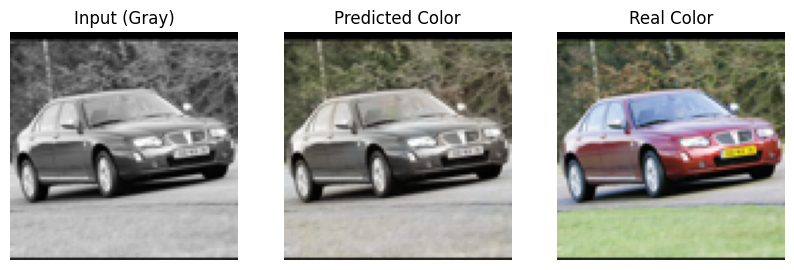

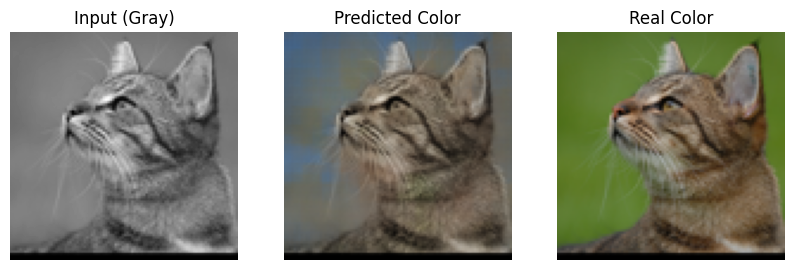

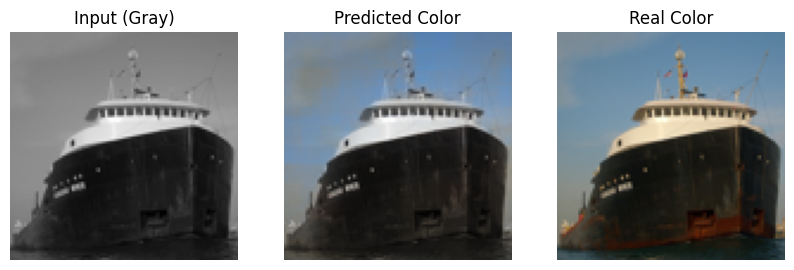

In [83]:
predicted = vae.predict(gray_input)

for i in range(5):
    show_result(i)

In [97]:
ssim, psnr,lpips = evaluate_model(vae,test_dataset)

Procesando imágenes:   0%|          | 0/1000 [00:00<?, ?it/s]


Resultados Finales:
------------------------------
SSIM : 0.9338
PSNR : 25.1147
LPIPS: 0.1485
------------------------------


In [84]:
encoder.save('encoder_cvae.keras')
decoder.save('decoder_cvae.keras')